# Early experiments

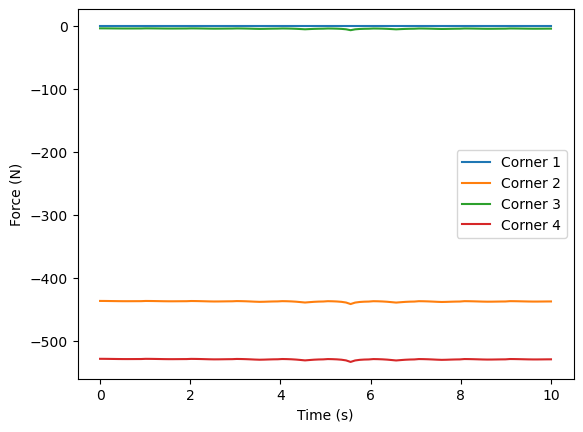

In [60]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
g = 9.81  # (m/s^2) Gravity
m = 10  # (kg) Mass dropped
h = 10  # (m) Height dropped from
cloth_size = (1, 1)  # (m) Width and height of cloth
cloth_resolution = (10, 10)  # Number of points in width and height
k = 1  #  (N/m) Spring constant
c = 1  # (N s/m) Damping constant
initial_drop_time = 0  # Time when mass is dropped

# Derived constants
cloth_mass = 1 / (cloth_resolution[0] * cloth_resolution[1])  #  (kg) Mass per point of cloth

# State variables
mass_present = True

def spring_damper_force(x1, x2, v1, v2):
    # Calculate spring and damper force between two points
    dx = x1 - x2
    dv = v1 - v2
    return -k * dx - c * dv

def cloth_ode(t, y):
    global mass_present

    # Unpack current positions and velocities
    # positions = y[:cloth_resolution[0]*cloth_resolution[1]].reshape(cloth_resolution)
    # velocities = y[cloth_resolution[0]*cloth_resolution[1]:].reshape(cloth_resolution)
    positions = y[:100].reshape(cloth_resolution)
    velocities = y[100:200].reshape(cloth_resolution)

    # Initialize forces to gravity
    forces = np.full(cloth_resolution, -g * cloth_mass)

    # Add forces due to spring/dampers with neighboring points
    for i in range(cloth_resolution[0]):
        for j in range(cloth_resolution[1]):
            if i > 0:  # Left
                forces[i, j] += spring_damper_force(positions[i, j], positions[i-1, j], velocities[i, j], velocities[i-1, j])
            if i < cloth_resolution[0]-1:  # Right
                forces[i, j] += spring_damper_force(positions[i, j], positions[i+1, j], velocities[i, j], velocities[i+1, j])
            if j > 0:  # Down
                forces[i, j] += spring_damper_force(positions[i, j], positions[i, j-1], velocities[i, j], velocities[i, j-1])
            if j < cloth_resolution[1]-1:  # Up
                forces[i, j] += spring_damper_force(positions[i, j], positions[i, j+1], velocities[i, j], velocities[i, j+1])

    # Check if mass has bounced
    if mass_present and positions[cloth_resolution[0]//2, cloth_resolution[1]//2] > 0:
        mass_present = False

    # Add force from dropped mass
    if mass_present:
        forces[cloth_resolution[0]//2, cloth_resolution[1]//2] += -g * m

    # Convert forces to accelerations
    accelerations = forces / cloth_mass

    # Return derivatives
    return np.concatenate((velocities.flatten(), accelerations.flatten()))

# Initial conditions
y0 = np.zeros(cloth_resolution[0]*cloth_resolution[1]*2)

# Time points to solve at
t_eval = np.linspace(0, 10, 100) #1, 10, 1000

# Solve ODE
solution = solve_ivp(cloth_ode, (0, 10), y0, t_eval=t_eval, method='RK45')

# Calculate forces at corners
forces_at_corners = np.empty((len(t_eval), 4))
forces_at_corners[:, 0] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, 0, 0] * cloth_mass * g
forces_at_corners[:, 1] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, -1, 0] * cloth_mass * g
forces_at_corners[:, 2] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, 0, -1] * cloth_mass * g
forces_at_corners[:, 3] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, -1, -1] * cloth_mass * g

# Plot forces at corners
plt.figure()
for i in range(4):
    plt.plot(t_eval, forces_at_corners[:, i], label=f"Corner {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()
plt.show()

Animation:

In [ ]:
import bpy
import bmesh
import numpy as np
from scipy.integrate import solve_ivp

# Constants
g = 9.81  # Gravity
m = 1  # Mass dropped
h = 10  # Height dropped from
cloth_size = (1, 1)  # Width and height of cloth
cloth_resolution = (10, 10)  # Number of points in width and height
k = 0.1  # Spring constant
c = 1  # Damping constant
initial_drop_time = 0  # Time when mass is dropped

# Derived constants
cloth_mass = 1 / (cloth_resolution[0] * cloth_resolution[1])  # Mass per point of cloth

# State variables
mass_present = True

def spring_damper_force(x1, x2, v1, v2):
    # Calculate spring and damper force between two points
    dx = x1 - x2
    dv = v1 - v2
    return -k * dx - c * dv

def cloth_ode(t, y):
    global mass_present

    # Unpack current positions and velocities
    positions = y[:cloth_resolution[0]*cloth_resolution[1]].reshape(cloth_resolution)
    velocities = y[cloth_resolution[0]*cloth_resolution[1]:].reshape(cloth_resolution)

    # Initialize forces to gravity
    forces = np.full(cloth_resolution, -g * cloth_mass)

    # Add forces due to spring/dampers with neighboring points
    for i in range(cloth_resolution[0]):
        for j in range(cloth_resolution[1]):
            if i > 0:  # Left
                forces[i, j] += spring_damper_force(positions[i, j], positions[i-1, j], velocities[i, j], velocities[i-1, j])
            if i < cloth_resolution[0]-1:  # Right
                forces[i, j] += spring_damper_force(positions[i, j], positions[i+1, j], velocities[i, j], velocities[i+1, j])
            if j > 0:  # Down
                forces[i, j] += spring_damper_force(positions[i, j], positions[i, j-1], velocities[i, j], velocities[i, j-1])
            if j < cloth_resolution[1]-1:  # Up
                forces[i, j] += spring_damper_force(positions[i, j], positions[i, j+1], velocities[i, j], velocities[i, j+1])

    # Check if mass has bounced
    if mass_present and positions[cloth_resolution[0]//2, cloth_resolution[1]//2] > 0:
        mass_present = False

    # Add force from dropped mass
    if mass_present:
        forces[cloth_resolution[0]//2, cloth_resolution[1]//2] += -g * m

    # Convert forces to accelerations
    accelerations = forces / cloth_mass

    # Return derivatives
    return np.concatenate((velocities.flatten(), accelerations.flatten()))

# Initial conditions
y0 = np.zeros(cloth_resolution[0]*cloth_resolution[1]*2)

# Time points to solve at
t_eval = np.linspace(0, 10, 100) #1, 10, 1000

# Solve ODE
solution = solve_ivp(cloth_ode, (0, 10), y0, t_eval=t_eval, method='Radau')

# Calculate forces at corners
forces_at_corners = np.empty((len(t_eval), 4))
forces_at_corners[:, 0] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, 0, 0] * cloth_mass * g
forces_at_corners[:, 1] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, -1, 0] * cloth_mass * g
forces_at_corners[:, 2] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, 0, -1] * cloth_mass * g
forces_at_corners[:, 3] = solution.y[:cloth_resolution[0]*cloth_resolution[1]].reshape((len(t_eval),) + cloth_resolution)[:, -1, -1] * cloth_mass * g

# Create a new mesh object with vertices at the initial positions
bpy.ops.object.select_all(action='DESELECT')
bpy.ops.object.select_by_type(type='MESH')
bpy.ops.object.delete()

# Create new mesh and object
mesh = bpy.data.meshes.new("cloth_mesh")
obj = bpy.data.objects.new("cloth_object", mesh)

# Link object to the scene
scene = bpy.context.scene
scene.collection.objects.link(obj)
scene.view_layers[0].objects.active = obj
obj.select_set(True)

# Create mesh from given verts, edges, faces. 
bm = bmesh.new()
bm.from_mesh(mesh)
bm.clear()

# Create vertices
for i in range(cloth_resolution[0]):
    for j in range(cloth_resolution[1]):
        bm.verts.new((i/cloth_resolution[0], j/cloth_resolution[1], 0))

# Ensure lookup table is up to date
bm.verts.ensure_lookup_table()

# Create faces
for i in range(cloth_resolution[0]-1):
    for j in range(cloth_resolution[1]-1):
        bm.faces.new([bm.verts[i*cloth_resolution[0]+j], 
                      bm.verts[(i+1)*cloth_resolution[0]+j], 
                      bm.verts[(i+1)*cloth_resolution[0]+(j+1)], 
                      bm.verts[i*cloth_resolution[0]+(j+1)]])

bm.to_mesh(mesh)
bm.free()

# Set up rendering
bpy.context.scene.render.image_settings.file_format = 'PNG'
bpy.context.scene.render.filepath = "C:/Users/gii2/OneDrive/Documenti/1. BFH AHB Mitarbeiter/Beurteilungsstelle SSSN/Blender/file.png" 

# Define the time step
dt = t_eval[1] - t_eval[0]

# Run the simulation
frame_number = 0
for t in t_eval:
    # Calculate the new positions and update the mesh vertices
    solution = solve_ivp(cloth_ode, (t, t+dt), y0, method='Radau')
    y = solution.y
    new_positions = y[:100, -1].reshape(cloth_resolution)

    # Ensure lookup table is up to date before accessing vertices by index
    #mesh.vertices.ensure_lookup_table()

    for i in range(cloth_resolution[0]):
        for j in range(cloth_resolution[1]):
            mesh.vertices[i*cloth_resolution[0]+j].co.z = new_positions[i, j]

    # Update initial conditions for the next step
    y0 = y[:, -1]

    # Render the scene
    bpy.context.scene.render.filepath = f"C:/Users/gii2/OneDrive/Documenti/1. BFH AHB Mitarbeiter/Beurteilungsstelle SSSN/Blender/file{frame_number:04}.png"
    bpy.ops.render.render(write_still=True)

    frame_number += 1

# Taichi

https://docs.taichi-lang.org/blog/head-first-taichi

### Tutorial

In [ ]:
import os
import taichi as ti

ti.init(arch=ti.cuda) # Alternatively, ti.init(arch=ti.cpu)

N = 128
cell_size = 1.0 / N
gravity = 9.81 #0.5
stiffness = 10000 #1600
damping = 20 #2
dt = 5e-4

ball_radius = 0.2
ball_center = ti.Vector.field(3, float, (1,))

x = ti.Vector.field(3, float, (N, N))
v = ti.Vector.field(3, float, (N, N))

num_triangles = (N - 1) * (N - 1) * 2
indices = ti.field(int, num_triangles * 3)
vertices = ti.Vector.field(3, float, N * N)
# result_dir = "C:/Users/gii2/OneDrive/Documenti/1. BFH AHB Mitarbeiter/Beurteilungsstelle SSSN/Simulations"
# video_manager = ti.tools.VideoManager(output_dir=result_dir, framerate=24, automatic_build=False)

def init_scene():
    for i, j in ti.ndrange(N, N):
        x[i, j] = ti.Vector([i * cell_size ,
                             j * cell_size / ti.sqrt(2),
                             (N - j) * cell_size / ti.sqrt(2)])
    ball_center[0] = ti.Vector([0.5, -0.5, -0.0])

@ti.kernel
def set_indices():
    for i, j in ti.ndrange(N, N):
        if i < N - 1 and j < N - 1:
            square_id = (i * (N - 1)) + j
            # 1st triangle of the square
            indices[square_id * 6 + 0] = i * N + j
            indices[square_id * 6 + 1] = (i + 1) * N + j
            indices[square_id * 6 + 2] = i * N + (j + 1)
            # 2nd triangle of the square
            indices[square_id * 6 + 3] = (i + 1) * N + j + 1
            indices[square_id * 6 + 4] = i * N + (j + 1)
            indices[square_id * 6 + 5] = (i + 1) * N + j

links = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [1, -1], [-1, 1], [1, 1]]
links = [ti.Vector(v) for v in links]

@ti.kernel
def step():
    for i in ti.grouped(x):
        v[i].y -= gravity * dt
    for i in ti.grouped(x):
        force = ti.Vector([0.0,0.0,0.0])
        for d in ti.static(links):
            j = min(max(i + d, 0), [N-1,N-1])
            relative_pos = x[j] - x[i]
            current_length = relative_pos.norm()
            original_length = cell_size * float(i-j).norm()
            if original_length != 0:
                force +=  stiffness * relative_pos.normalized() * (current_length - original_length) / original_length
        v[i] +=  force * dt
    for i in ti.grouped(x):
        v[i] *= ti.exp(-damping * dt)
        if (x[i]-ball_center[0]).norm() <= ball_radius:
            v[i] = ti.Vector([0.0, 0.0, 0.0])
        x[i] += dt * v[i]

@ti.kernel
def set_vertices():
    for i, j in ti.ndrange(N, N):
        vertices[i * N + j] = x[i, j]

init_scene()
set_indices()

for i in range(30):
    step()
    set_vertices()

# video_manager.write_frame(pixels_img)

# print()
# print('Exporting .mp4 and .gif videos...')
# video_manager.make_video(gif=True, mp4=True)
# print(f'MP4 video is saved to {video_manager.get_output_filename(".mp4")}')
# print(f'GIF video is saved to {video_manager.get_output_filename(".gif")}')

window = ti.ui.Window("Cloth", (800, 800), vsync=True)
canvas = window.get_canvas()
scene = ti.ui.Scene()
camera = ti.ui.Camera()

while window.running:
    for i in range(30):
        step()
    set_vertices()

    camera.position(0.5, -0.5, 2)
    camera.lookat(0.5, -0.5, 0)
    scene.set_camera(camera)

    scene.point_light(pos=(0.5, 1, 2), color=(1, 1, 1))
    scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), two_sided = True)
    scene.particles(ball_center, radius=ball_radius, color=(0.5, 0, 0))
    canvas.scene(scene)
    window.show()

### Playground

#### Infinite simulation:

In [2]:
import os
import taichi as ti

ti.init(arch=ti.cuda) # Alternatively, ti.init(arch=ti.cpu)

N = 128
cell_size = 1.0 / N
gravity = 9.81
stiffness = 1600
damping = 5
dt = 5e-4

ball_radius = 0.1
ball_center = ti.Vector.field(3, float, (1,))
ball_velocity = ti.Vector.field(3, float, (1,))

x = ti.Vector.field(3, float, (N, N))
v = ti.Vector.field(3, float, (N, N))

num_triangles = (N - 1) * (N - 1) * 2
indices = ti.field(int, num_triangles * 3)
vertices = ti.Vector.field(3, float, N * N)

def init_scene():
    for i, j in ti.ndrange(N, N):
        x[i, j] = ti.Vector([i * cell_size, 0.0, j * cell_size])
    ball_center[0] = ti.Vector([0.5, 1, 0.25]) # Ball starts from a height
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

@ti.kernel
def set_indices():
    for i, j in ti.ndrange(N, N):
        if i < N - 1 and j < N - 1:
            square_id = (i * (N - 1)) + j
            # 1st triangle of the square
            indices[square_id * 6 + 0] = i * N + j
            indices[square_id * 6 + 1] = (i + 1) * N + j
            indices[square_id * 6 + 2] = i * N + (j + 1)
            # 2nd triangle of the square
            indices[square_id * 6 + 3] = (i + 1) * N + j + 1
            indices[square_id * 6 + 4] = i * N + (j + 1)
            indices[square_id * 6 + 5] = (i + 1) * N + j

links = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [1, -1], [-1, 1], [1, 1]]
links = [ti.Vector(v) for v in links]

# Create Taichi fields to store the forces at the corners
force_top_left = ti.field(dtype=float, shape=(1,))
force_top_right = ti.field(dtype=float, shape=(1,))
force_bottom_left = ti.field(dtype=float, shape=(1,))
force_bottom_right = ti.field(dtype=float, shape=(1,))

@ti.kernel
def step():
    # Declare the variable to store the force exerted by the net on the ball
    net_force_on_ball = ti.Vector([0.0, 0.0, 0.0])

    for i in ti.grouped(x):
        force = ti.Vector([0.0,0.0,0.0])
        for d in ti.static(links):
            j = min(max(i + d, 0), [N-1,N-1])
            relative_pos = x[j] - x[i]
            current_length = relative_pos.norm()
            original_length = cell_size * float(i-j).norm()
            if original_length != 0:
                force +=  stiffness * relative_pos.normalized() * (current_length - original_length) / original_length
        v[i] +=  force * dt
        
        # If it's a corner node, store the norm of the force to the appropriate field
        if i[0] == 0 and i[1] == 0:
            force_bottom_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == 0:
            force_bottom_right[0] = force.norm()
        elif i[0] == 0 and i[1] == N-1:
            force_top_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == N-1:
            force_top_right[0] = force.norm()

    for i in ti.grouped(x):
        v[i] *= ti.exp(-damping * dt)
        displacement = x[i]-ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            x[i] += penetration_depth * collision_normal
            v[i] += collision_normal * 10.0  # increased response factor
            net_force_on_ball -= collision_normal * 10.0  # Accumulate the force exerted by the net on the ball

        # Check if it is an edge node
        if i[0] != 0 and i[0] != N-1 and i[1] != 0 and i[1] != N-1:
            x[i] += dt * v[i]

    # Add motion for the ball
    ball_velocity[0].y -= gravity * dt # Gravity acts on ball
    ball_velocity[0] += net_force_on_ball * dt # Add the force from the net to the ball's velocity
    if (ball_center[0] - ti.Vector([0.5, 0.0, 0.0])).norm() <= ball_radius: # Ground collision
        ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0])
    ball_center[0] += dt * ball_velocity[0]

@ti.kernel
def set_vertices():
    for i, j in ti.ndrange(N, N):
        vertices[i * N + j] = x[i, j]

total_simulation_time = 5.0  # in seconds
steps = int(total_simulation_time / dt)  # Calculate the number of steps needed

init_scene()
set_indices()

# Python lists to store forces over time
force_top_left_list = []
force_top_right_list = []
force_bottom_left_list = []
force_bottom_right_list = []

for i in range(30):
    step()

    # Append forces to lists
    force_top_left_list.append(force_top_left[0])
    force_top_right_list.append(force_top_right[0])
    force_bottom_left_list.append(force_bottom_left[0])
    force_bottom_right_list.append(force_bottom_right[0])

    set_vertices()

window = ti.ui.Window("Cloth", (800, 800), vsync=True)
canvas = window.get_canvas()
scene = ti.ui.Scene()
camera = ti.ui.Camera()

while window.running:
    for i in range(30):
        step()
    set_vertices()

    camera.position(0.5, 1.6, 1.1) # Adjust camera position
    camera.lookat(0.5, 0.5, 0.7) # Adjust lookat point
    scene.set_camera(camera)

    scene.point_light(pos=(0.5, 1, 2), color=(1, 1, 1))
    scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), two_sided = True)
    scene.particles(ball_center, radius=ball_radius, color=(0.5, 0, 0))
    canvas.scene(scene)
    window.show()

RuntimeError: create_directories: unknown error: "C:/taichi_cache/ticache"

#### Finite simulation:

##### Mass indipendent:

step() function:

1. At the start of the step function, a variable net_force_on_ball is declared, which will store the total force exerted by the net on the ball. It's initialized to zero in all three dimensions (x, y, z).

2. The first for loop over i iterates through all the nodes in the net. For each node, it calculates the force exerted on that node by its neighbors using Hooke's law (which describes the force in a spring).

    - It starts by initializing a zero vector force for the node at i.

    - It then loops over each link d in links, calculates the relative position of the neighboring node j to the current node i, the current length of the link, and the original length of the link.

    - If the original length is not zero, it calculates the force exerted by the link, which is proportional to the difference in the current length and the original length. The force is directed along the link and is added to the total force on the node at i.

    - The velocity of the node i is updated according to the calculated force and the time step dt.

    - If the node i is one of the four corner nodes of the net, the norm of the force on the node is recorded in the appropriate field.

3. The second for loop over i applies damping to the velocity of each node, checks if the node is inside the ball, applies a collision response if it is, and updates the position of the node if it's not an edge node.

    - The damping is applied to the velocity of each node to simulate air resistance or internal friction in the net material.

    - It then calculates the displacement and distance of the node from the center of the ball. If the distance is less than or equal to the radius of the ball, it calculates the collision normal, which is the direction from the center of the ball to the node. It then moves the node out of the ball along the collision normal, increases the velocity of the node in the direction of the collision normal, and accumulates the force exerted on the ball by the node in net_force_on_ball.

    - If the node i is not an edge node (i.e., not on the boundaries of the net), its position is updated according to its velocity and the time step dt.

4. After updating all the nodes, it applies gravity to the ball, adds the total force from the net to the ball's velocity, checks if the ball has hit the ground, and updates the position of the ball.

    - It subtracts gravity * dt from the y-component of the ball's velocity to simulate the effect of gravity.

    - It then adds the net force on the ball (calculated from the collisions with the net) to the ball's velocity.

    - It checks if the ball has collided with the ground. If it has, it sets the ball's velocity to zero.

    - Finally, it updates the position of the ball according to its velocity and the time step dt.

In [1]:
import os
import taichi as ti

ti.init(arch=ti.cuda) # Alternatively, ti.init(arch=ti.cpu)

N = 128
cell_size = 1.0 / N
gravity = 9.81
stiffness = 500 #1600  good results with 500 and 20
damping = 20 #5
dt = 5e-4

ball_radius = 0.1
ball_center = ti.Vector.field(3, float, (1,))
ball_velocity = ti.Vector.field(3, float, (1,))

x = ti.Vector.field(3, float, (N, N))
v = ti.Vector.field(3, float, (N, N))

num_triangles = (N - 1) * (N - 1) * 2
indices = ti.field(int, num_triangles * 3)
vertices = ti.Vector.field(3, float, N * N)

def init_scene():
    for i, j in ti.ndrange(N, N):
        x[i, j] = ti.Vector([i * cell_size, 0.0, j * cell_size])
    ball_center[0] = ti.Vector([0.5, 1, 0.45]) #ti.Vector([0.5, 1, 0.25]) # 0.5, 1, 0.25 for a shifted impact. Ball starts from a height
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

@ti.kernel
def set_indices():
    for i, j in ti.ndrange(N, N):
        if i < N - 1 and j < N - 1:
            square_id = (i * (N - 1)) + j
            # 1st triangle of the square
            indices[square_id * 6 + 0] = i * N + j
            indices[square_id * 6 + 1] = (i + 1) * N + j
            indices[square_id * 6 + 2] = i * N + (j + 1)
            # 2nd triangle of the square
            indices[square_id * 6 + 3] = (i + 1) * N + j + 1
            indices[square_id * 6 + 4] = i * N + (j + 1)
            indices[square_id * 6 + 5] = (i + 1) * N + j

links = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [1, -1], [-1, 1], [1, 1]]
links = [ti.Vector(v) for v in links]

# Create Taichi fields to store the forces at the corners
force_top_left = ti.field(dtype=float, shape=(1,))
force_top_right = ti.field(dtype=float, shape=(1,))
force_bottom_left = ti.field(dtype=float, shape=(1,))
force_bottom_right = ti.field(dtype=float, shape=(1,))

@ti.kernel
def step():

    # Declare the variable to store the force exerted by the net on the ball
    net_force_on_ball = ti.Vector([0.0, 0.0, 0.0])

    for i in ti.grouped(x):
        force = ti.Vector([0.0,0.0,0.0])
        for d in ti.static(links):
            j = min(max(i + d, 0), [N-1,N-1])
            relative_pos = x[j] - x[i]
            current_length = relative_pos.norm()
            original_length = cell_size * float(i-j).norm()
            if original_length != 0:
                force +=  stiffness * relative_pos.normalized() * (current_length - original_length) / original_length
        v[i] +=  force * dt
        
        # If it's a corner node, store the norm of the force to the appropriate field
        if i[0] == 0 and i[1] == 0:
            force_bottom_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == 0:
            force_bottom_right[0] = force.norm()
        elif i[0] == 0 and i[1] == N-1:
            force_top_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == N-1:
            force_top_right[0] = force.norm()

    for i in ti.grouped(x):
        v[i] *= ti.exp(-damping * dt)
        displacement = x[i]-ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            x[i] += penetration_depth * collision_normal
            v[i] += collision_normal * 10.0  # increased response factor
            net_force_on_ball -= collision_normal * 10.0  # Accumulate the force exerted by the net on the ball, simplified

        # Check if it is an edge node
        if i[0] != 0 and i[0] != N-1 and i[1] != 0 and i[1] != N-1:
            x[i] += dt * v[i]

    # Add motion for the ball
    ball_velocity[0].y -= gravity * dt # Gravity acts on ball
    ball_velocity[0] += net_force_on_ball * dt # Add the force from the net to the ball's velocity
    if (ball_center[0] - ti.Vector([0.5, 0.0, 0.0])).norm() <= ball_radius: # Ground collision
        ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0])
    ball_center[0] += dt * ball_velocity[0]

@ti.kernel
def set_vertices():
    for i, j in ti.ndrange(N, N):
        vertices[i * N + j] = x[i, j]

total_simulation_time = 5  # in seconds
steps = int(total_simulation_time / dt)  # Calculate the number of steps needed

init_scene()
set_indices()

# # Set colors for each vertices

# # Create a vector field with shape matching the vertices field
# per_vertex_color = ti.Vector.field(3, dtype=float, shape=vertices.shape)

# @ti.kernel
# def fill_colors():
#     # Loop over all vertices
#     for i in ti.grouped(vertices):
#         # Assign a color to each vertex. Replace this with your own logic.
#         per_vertex_color[i] = ti.Vector([1.0, 0.0, 0.0])  # Set all vertices to red

# # Fill the field with colors
# fill_colors()

# scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), per_vertex_color=per_vertex_color, two_sided = True)

# Define separate variables for corner forces
force_bottom_left_value = 0.0
force_bottom_right_value = 0.0
force_top_left_value = 0.0
force_top_right_value = 0.0

# Initialize empty lists for corner forces
force_bottom_left_list = []
force_bottom_right_list = []
force_top_left_list = []
force_top_right_list = []

# Initialize an empty list to store ball positions
ball_positions = []

window = ti.ui.Window("Cloth", (800, 800), vsync=True)
canvas = window.get_canvas()
scene = ti.ui.Scene()
camera = ti.ui.Camera()

for i in range(steps):  # Loop runs for 'steps' iterations, which corresponds to 5 seconds
    step()

    # Assign forces directly to the variables
    force_bottom_left_value = force_bottom_left[0]
    force_bottom_right_value = force_bottom_right[0]
    force_top_left_value = force_top_left[0]
    force_top_right_value = force_top_right[0]

    # Append forces to the lists
    force_bottom_left_list.append(force_bottom_left_value)
    force_bottom_right_list.append(force_bottom_right_value)
    force_top_left_list.append(force_top_left_value)
    force_top_right_list.append(force_top_right_value)

    # Append the ball position to the list
    ball_positions.append(ball_center[0].to_numpy())

    set_vertices()

    if i % 30 == 0:  # Update the visualization every 30 steps
        camera.position(0.5, 0.5, 3.0)  # Adjusted camera position; X = destra/sinistra, y = altezza, z = distanza dalla scena
        camera.lookat(0.5, 0.5, 0.7)  # Adjusted lookat point
        scene.set_camera(camera)

        scene.point_light(pos=(0.5, 1, 2), color=(1, 1, 1))
        scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), two_sided = True)
        scene.particles(ball_center, radius=ball_radius, color=(0.5, 0, 0))
        canvas.scene(scene)
        window.show()

    if i == steps - 1:  # Close the window after the simulation is done
        break

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.3
[Taichi] Starting on arch=x64


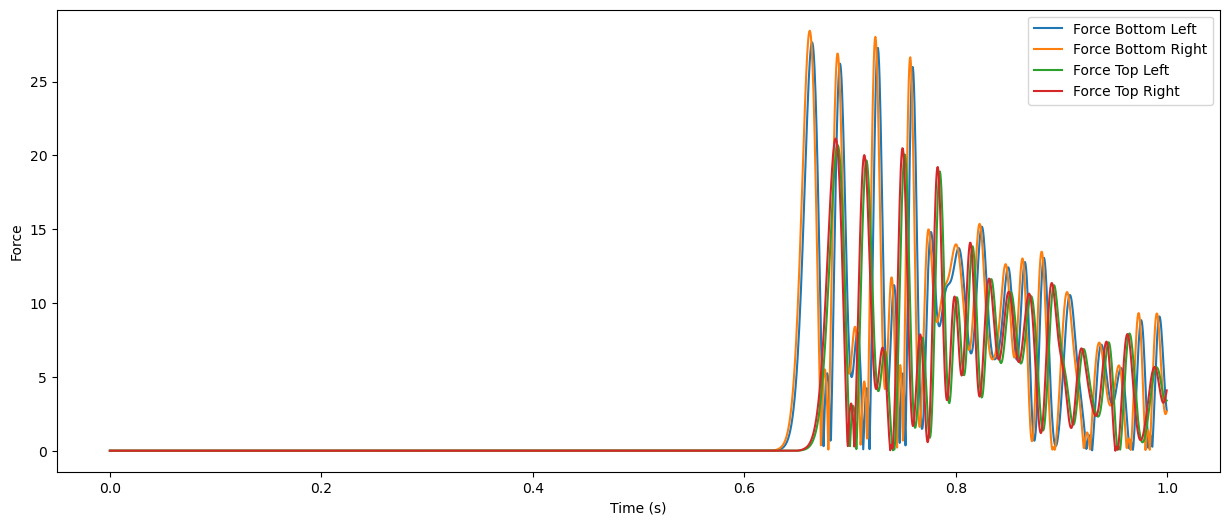

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

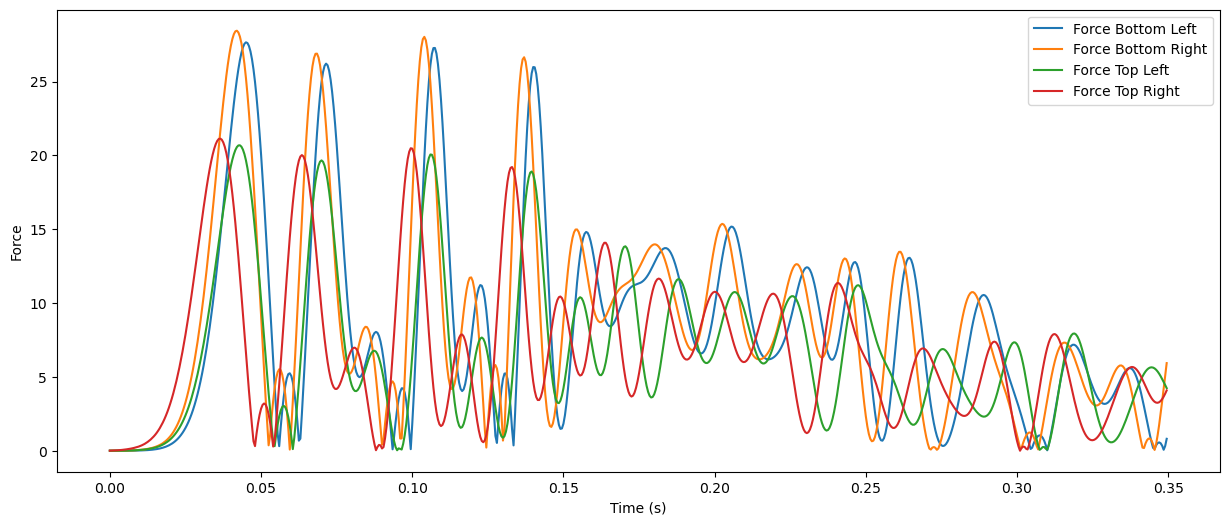

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
force_bottom_left_filtered = [f for f in force_bottom_left_list if f > 0]
force_bottom_right_filtered = [f for f in force_bottom_right_list if f > 0]
force_top_left_filtered = [f for f in force_top_left_list if f > 0]
force_top_right_filtered = [f for f in force_top_right_list if f > 0]

# Ensure filtered force arrays have the same length as time
num_filtered = min(len(time), len(force_bottom_left_filtered), len(force_bottom_right_filtered), len(force_top_left_filtered), len(force_top_right_filtered))
time = time[:num_filtered]
force_bottom_left_filtered = force_bottom_left_filtered[:num_filtered]
force_bottom_right_filtered = force_bottom_right_filtered[:num_filtered]
force_top_left_filtered = force_top_left_filtered[:num_filtered]
force_top_right_filtered = force_top_right_filtered[:num_filtered]

plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_filtered, label='Force Bottom Left')
plt.plot(time, force_bottom_right_filtered, label='Force Bottom Right')
plt.plot(time, force_top_left_filtered, label='Force Top Left')
plt.plot(time, force_top_right_filtered, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

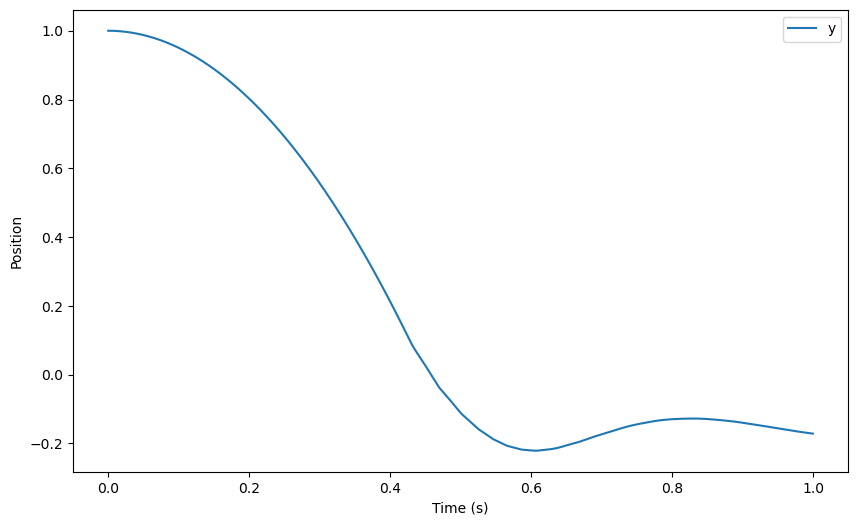

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the ball_positions list to a NumPy array
ball_positions = np.array(ball_positions)

# Adjust the lengths of time and ball position arrays
time = np.arange(steps) * dt
num_positions = min(len(time), ball_positions.shape[0])
time = time[:num_positions]
ball_positions = ball_positions[:num_positions]

# Extract x, y, z positions separately
ball_x = ball_positions[:, 0]
ball_y = ball_positions[:, 1]
ball_z = ball_positions[:, 2]

# Plot the time/position diagram
plt.figure(figsize=(10, 6))
#plt.plot(time, ball_x, label='x')
plt.plot(time, ball_y, label='y')
#plt.plot(time, ball_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.show()

##### Mass dependent:

Collision update:

In the previous model, when the ball collides with a node, the node gets pushed out of the ball along the collision normal, and it gains a velocity in the direction of the collision normal. The ball's velocity isn't affected by the collision, but it does experience a force due to the net acting on it.

To make this more physically accurate, both the ball and the node could experience forces due to the collision that follow Newton's third law: for every action, there is an equal and opposite reaction.

1. Compute the penetration depth of the node into the ball along the collision normal.
2. Compute a collision response force that's proportional to this penetration depth. This force pushes both the node and the ball apart. Make the force stronger for deeper penetrations by making it proportional to the square of the penetration depth, for example. This is known as a penalty method, and it simulates the way real objects deform and resist deformation more when they're compressed more. Choose a proportionality constant that gives you a good balance between stability and accuracy. In real units, this constant would have units of pressure (force per unit area), but in the simulation, one might just need to choose a constant that gives good results.
3. Apply this collision response force to both the node and the ball, but in opposite directions. For the node, this force would be added to the forces due to the "springs" that we're already calculating. For the ball, this would be an additional force that we'd need to account for when updating the ball's velocity and position.
4. Optionally, add a damping force that's proportional to the relative velocity of the ball and node along the collision normal. This simulates the way collisions in real life aren't perfectly elastic, and some kinetic energy gets turned into heat or other forms of energy. This damping force would resist the motion of the ball and node away from each other after the collision. Like the collision response force, it would be applied to both the ball and the node in opposite directions.

In [1]:
import taichi as ti

ti.init(arch=ti.cuda) # Alternatively, ti.init(arch=ti.cpu)

# General variables
gravity = 9.81
dt = 5e-5 #-4 time step would be realistic, but it's unstable

# Net properties
N = 128
cell_size = 1.0 / N
stiffness = 1e5 # Pascals (Pa)  good results with 500 and 20
damping = 1000 # 5
node_mass_kg = 1 # kg

# Ball properties
ball_radius = 0.1
ball_mass_kg = 10.0  # kg. Reinforced concrete ball with a radius of 10 cm, density of 2400 kg/m^3.

# Collision properties
k = 1e6  # proportionality constant for collision response force
damping_ratio = 0.1  # damping ratio for collision


# Initialize Taichi objects
node_mass = ti.field(dtype=float, shape=(N,N))
ball_mass = ti.field(dtype=float, shape=())
node_mass.fill(node_mass_kg)
ball_mass[None] = ball_mass_kg

ball_center = ti.Vector.field(3, float, (1,))
ball_velocity = ti.Vector.field(3, float, (1,))

x = ti.Vector.field(3, float, (N, N))
v = ti.Vector.field(3, float, (N, N))

num_triangles = (N - 1) * (N - 1) * 2
indices = ti.field(int, num_triangles * 3)
vertices = ti.Vector.field(3, float, N * N)

def init_scene():
    for i, j in ti.ndrange(N, N):
        x[i, j] = ti.Vector([i * cell_size, 0.0, j * cell_size])
    ball_center[0] = ti.Vector([0.5, 1, 0.45]) #ti.Vector([0.5, 1, 0.25]) # 0.5, 1, 0.25 for a shifted impact. Ball starts from a height
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

@ti.kernel
def set_indices():
    for i, j in ti.ndrange(N, N):
        if i < N - 1 and j < N - 1:
            square_id = (i * (N - 1)) + j
            # 1st triangle of the square
            indices[square_id * 6 + 0] = i * N + j
            indices[square_id * 6 + 1] = (i + 1) * N + j
            indices[square_id * 6 + 2] = i * N + (j + 1)
            # 2nd triangle of the square
            indices[square_id * 6 + 3] = (i + 1) * N + j + 1
            indices[square_id * 6 + 4] = i * N + (j + 1)
            indices[square_id * 6 + 5] = (i + 1) * N + j

links = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [1, -1], [-1, 1], [1, 1]]
links = [ti.Vector(v) for v in links]

# Create Taichi fields to store the forces at the corners
force_top_left = ti.field(dtype=float, shape=(1,))
force_top_right = ti.field(dtype=float, shape=(1,))
force_bottom_left = ti.field(dtype=float, shape=(1,))
force_bottom_right = ti.field(dtype=float, shape=(1,))

@ti.kernel
def step():

    for i in ti.grouped(x):
        force = ti.Vector([0.0,0.0,0.0])
        for d in ti.static(links):
            j = min(max(i + d, 0), [N-1,N-1])
            relative_pos = x[j] - x[i]
            current_length = relative_pos.norm()
            original_length = cell_size * float(i-j).norm()
            if original_length != 0:
                force +=  stiffness * relative_pos.normalized() * (current_length - original_length) / original_length
        #force.y -= node_mass[i] * gravity # Adding gravitational pull on the net
        v[i] +=  (force / node_mass[i]) * dt  # consider mass when updating velocity

        # If it's a corner node, store the norm of the force to the appropriate field
        if i[0] == 0 and i[1] == 0:
            force_bottom_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == 0:
            force_bottom_right[0] = force.norm()
        elif i[0] == 0 and i[1] == N-1:
            force_top_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == N-1:
            force_top_right[0] = force.norm()

    for i in ti.grouped(x):
        v[i] *= ti.exp(-damping * dt)
        displacement = x[i] - ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            collision_response_force = k * penetration_depth ** 2 * collision_normal  # collision response force
            relative_velocity = v[i] - ball_velocity[0]  # relative velocity of the node and the ball
            damping_force = damping_ratio * relative_velocity.dot(collision_normal) * collision_normal  # damping force

            # Update the node's position and velocity
            x[i] += penetration_depth * collision_normal
            v[i] += (collision_response_force * dt - damping_force * dt) / node_mass[i]  # consider mass when updating velocity

            # Update the ball's velocity
            ball_velocity[0] -= (collision_response_force * dt - damping_force * dt) / ball_mass[None]  # consider mass when updating velocity

        # Conditions for the angle points of the net
        if i[0] != 0 and i[0] != N-1 and i[1] != 0 and i[1] != N-1:
            x[i] += dt * v[i]

    # Add motion for the ball
    ball_velocity[0].y -= gravity * dt  # Gravity acts on ball
    ball_center[0] += dt * ball_velocity[0]

@ti.kernel
def set_vertices():
    for i, j in ti.ndrange(N, N):
        vertices[i * N + j] = x[i, j]

total_simulation_time = 1  # in seconds
steps = int(total_simulation_time / dt)  # Calculate the number of steps needed

init_scene()
set_indices()

# Define separate variables for corner forces
force_bottom_left_value = 0.0
force_bottom_right_value = 0.0
force_top_left_value = 0.0
force_top_right_value = 0.0

# Initialize empty lists for corner forces
force_bottom_left_list = []
force_bottom_right_list = []
force_top_left_list = []
force_top_right_list = []

# Initialize an empty list to store ball positions
ball_positions = []

window = ti.ui.Window("Cloth", (800, 800), vsync=True)
canvas = window.get_canvas()
scene = ti.ui.Scene()
camera = ti.ui.Camera()

for i in range(steps):  # Loop runs for 'steps' iterations, which corresponds to 5 seconds
    step()

    # Assign forces directly to the variables
    force_bottom_left_value = force_bottom_left[0]
    force_bottom_right_value = force_bottom_right[0]
    force_top_left_value = force_top_left[0]
    force_top_right_value = force_top_right[0]

    # Append forces to the lists
    force_bottom_left_list.append(force_bottom_left_value)
    force_bottom_right_list.append(force_bottom_right_value)
    force_top_left_list.append(force_top_left_value)
    force_top_right_list.append(force_top_right_value)

    # Append the ball position to the list
    ball_positions.append(ball_center[0].to_numpy())

    set_vertices()

    if i % 30 == 0:  # Update the visualization every 30 steps
        camera.position(0.5, 0.2, 3.0)  # Adjusted camera position; X = destra/sinistra, y = altezza, z = distanza dalla scena
        camera.lookat(0.5, 0.5, 0.7)  # Adjusted lookat point
        scene.set_camera(camera)

        scene.point_light(pos=(0.5, 1, 2), color=(1, 1, 1))
        scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), two_sided = True)
        scene.particles(ball_center, radius=ball_radius, color=(0.5, 0, 0))
        canvas.scene(scene)
        window.show()

    if i == steps - 1:  # Close the window after the simulation is done
        break

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.3
[Taichi] Starting on arch=x64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

In [ ]:
# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
force_bottom_left_filtered = [f for f in force_bottom_left_list if f > 0]
force_bottom_right_filtered = [f for f in force_bottom_right_list if f > 0]
force_top_left_filtered = [f for f in force_top_left_list if f > 0]
force_top_right_filtered = [f for f in force_top_right_list if f > 0]

# Ensure filtered force arrays have the same length as time
num_filtered = min(len(time), len(force_bottom_left_filtered), len(force_bottom_right_filtered), len(force_top_left_filtered), len(force_top_right_filtered))
time = time[:num_filtered]
force_bottom_left_filtered = force_bottom_left_filtered[:num_filtered]
force_bottom_right_filtered = force_bottom_right_filtered[:num_filtered]
force_top_left_filtered = force_top_left_filtered[:num_filtered]
force_top_right_filtered = force_top_right_filtered[:num_filtered]

plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_filtered, label='Force Bottom Left')
plt.plot(time, force_bottom_right_filtered, label='Force Bottom Right')
plt.plot(time, force_top_left_filtered, label='Force Top Left')
plt.plot(time, force_top_right_filtered, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

In [ ]:
# Convert the ball_positions list to a NumPy array
ball_positions = np.array(ball_positions)

# Adjust the lengths of time and ball position arrays
time = np.arange(steps) * dt
num_positions = min(len(time), ball_positions.shape[0])
time = time[:num_positions]
ball_positions = ball_positions[:num_positions]

# Extract x, y, z positions separately
ball_x = ball_positions[:, 0]
ball_y = ball_positions[:, 1]
ball_z = ball_positions[:, 2]

# Plot the time/position diagram
plt.figure(figsize=(10, 6))
#plt.plot(time, ball_x, label='x')
plt.plot(time, ball_y, label='y')
#plt.plot(time, ball_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.show()

##### Ropes addition:

In [1]:
import taichi as ti

ti.init(arch=ti.cuda) # Alternatively, ti.init(arch=ti.cpu)

# General variables
gravity = 9.81
gravity_v = ti.Vector([0, -9.8, 0])
dt = 4e-2 #-4 time step would be realistic, but it's unstable
substeps = int(1 / 60 // dt)

# Net properties
N = 128
cell_size = 1.0 / N
stiffness = 1e5 #1e5 Pascals (Pa)
damping = 1000 #1000
node_mass_kg = 1 # kg

spring_Y = 3e4
dashpot_damping = 1e4
drag_damping = 1

# Rope properties
rope_length = 5*N  # five times longer than the net
friction_coefficient = 0.9  # adjust as needed
invalid_marker = 1e10

# Ball properties
ball_radius = 0.1
ball_mass_kg = 50.0  # 10 kg. Reinforced concrete ball with a radius of 10 cm, density of 2400 kg/m^3.

# Collision properties
k = 1e6  #1e6 proportionality constant for collision response force
damping_ratio = 0.1  #0.1 damping ratio for collision


# Initialize Taichi objects
obere_tragseil = ti.Vector.field(3, float, shape = rope_length)
untere_tragseil = ti.Vector.field(3, float, shape = rope_length)

node_mass = ti.field(dtype=float, shape=(N,N))
ball_mass = ti.field(dtype=float, shape=())
node_mass.fill(node_mass_kg)
ball_mass[None] = ball_mass_kg

ball_center = ti.Vector.field(3, float, (1,))
ball_velocity = ti.Vector.field(3, float, (1,))

x = ti.Vector.field(3, float, (N, N))
v = ti.Vector.field(3, float, (N, N))

num_triangles = (N - 1) * (N - 1) * 2
indices = ti.field(int, num_triangles * 3)
vertices = ti.Vector.field(3, float, N * N)
colors = ti.Vector.field(3, dtype=float, shape=N * N)

bending_springs = False

def init_scene():
    # Initialize the net points
    for i, j in ti.ndrange(N, N):
        x[i, j] = ti.Vector([i * cell_size, 0.0, j * cell_size])
    
    # Initialize the ball
    ball_center[0] = ti.Vector([0.5, 0.5, 0.45]) #ti.Vector([0.5, 1, 0.45]) # 0.5, 1, 0.25 for a shifted impact. Ball starts from a height of 1m
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

# Initialize the ropes
@ti.kernel
def init_obere_tragseil():
    for i in range(obere_tragseil.shape[0]):
        obere_tragseil[i] = ti.Vector([i * cell_size - 2, 0.0, 0.0])

@ti.kernel
def init_untere_tragseil():
    for i in range(untere_tragseil.shape[0]):
        untere_tragseil[i] = ti.Vector([i * cell_size - 2, 0.0, (N-1) * cell_size])

@ti.kernel
def initialize_mass_points():
    random_offset = ti.Vector([ti.random() - 0.5, ti.random() - 0.5]) * 0.1

    for i, j in x:
        x[i, j] = [
            i * cell_size - 0.5 + random_offset[0], 0.6,
            j * cell_size - 0.5 + random_offset[1]
        ]
        v[i, j] = [0, 0, 0]

@ti.kernel
def initialize_mesh_indices():
    for i, j in ti.ndrange(N - 1, N - 1):
        quad_id = (i * (N - 1)) + j
        # 1st triangle of the square
        indices[quad_id * 6 + 0] = i * N + j
        indices[quad_id * 6 + 1] = (i + 1) * N + j
        indices[quad_id * 6 + 2] = i * N + (j + 1)
        # 2nd triangle of the square
        indices[quad_id * 6 + 3] = (i + 1) * N + j + 1
        indices[quad_id * 6 + 4] = i * N + (j + 1)
        indices[quad_id * 6 + 5] = (i + 1) * N + j

    for i, j in ti.ndrange(N, N):
        if (i // 4 + j // 4) % 2 == 0:
            colors[i * N + j] = (0.22, 0.72, 0.52)
        else:
            colors[i * N + j] = (1, 0.334, 0.52)

initialize_mesh_indices()

spring_offsets = []
if bending_springs:
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (i, j) != (0, 0):
                spring_offsets.append(ti.Vector([i, j]))

else:
    for i in range(-2, 3):
        for j in range(-2, 3):
            if (i, j) != (0, 0) and abs(i) + abs(j) <= 2:
                spring_offsets.append(ti.Vector([i, j]))

# Springs
links = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [1, -1], [-1, 1], [1, 1]]
links = [ti.Vector(v) for v in links]

# Create Taichi fields to store the forces at the corners
force_top_left = ti.field(dtype=float, shape=(1,))
force_top_right = ti.field(dtype=float, shape=(1,))
force_bottom_left = ti.field(dtype=float, shape=(1,))
force_bottom_right = ti.field(dtype=float, shape=(1,))

@ti.kernel
def substep():
    for i in ti.grouped(x):
        v[i] += gravity * dt

    for i in ti.grouped(x):
        force = ti.Vector([0.0, 0.0, 0.0])
        for spring_offset in ti.static(spring_offsets):
            j = i + spring_offset
            if 0 <= j[0] < n and 0 <= j[1] < n:
                x_ij = x[i] - x[j]
                v_ij = v[i] - v[j]
                d = x_ij.normalized()
                current_dist = x_ij.norm()
                original_dist = cell_size * float(i - j).norm()
                # Spring force
                force += -spring_Y * d * (current_dist / original_dist - 1)
                # Dashpot damping
                force += -v_ij.dot(d) * d * dashpot_damping * cell_size

        v[i] += force * dt

        # If it's a corner node, store the norm of the force to the appropriate field
        if i[0] == 0 and i[1] == 0:
            force_bottom_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == 0:
            force_bottom_right[0] = force.norm()
        elif i[0] == 0 and i[1] == N-1:
            force_top_left[0] = force.norm()
        elif i[0] == N-1 and i[1] == N-1:
            force_top_right[0] = force.norm()

    for i in ti.grouped(x):
        v[i] *= ti.exp(-drag_damping * dt)
        displacement = x[i] - ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            collision_response_force = k * penetration_depth ** 2 * collision_normal  # collision response force
            relative_velocity = v[i] - ball_velocity[0]  # relative velocity of the node and the ball
            damping_force = damping_ratio * relative_velocity.dot(collision_normal) * collision_normal  # damping force

            # Update the node's position and velocity
            x[i] += penetration_depth * collision_normal
            v[i] += (collision_response_force * dt - damping_force * dt) / node_mass[i]  # consider mass when updating velocity

            # Update the ball's velocity
            ball_velocity[0] -= (collision_response_force * dt - damping_force * dt) / ball_mass[None]  # consider mass when updating velocity
          
        # Conditions for the angle points of the net
        if i[0] != 0 and i[0] != N-1 and i[1] != 0 and i[1] != N-1:
            x[i] += dt * v[i]

    # Add motion for the ball
    ball_velocity[0].y -= gravity * dt  # Gravity acts on ball
    ball_center[0] += dt * ball_velocity[0]

@ti.kernel
def update_boundary_nodes():
    for i in range(N):
        # Bottom boundary nodes
        node_position = x[i, 0]
        rope_position = untere_tragseil[i]
        direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
        v_projected = v[i, 0].dot(direction) * direction  # Project velocity onto rope direction
        v[i, 0] = v_projected  # Update velocity
        x[i, 0] += v_projected * dt  # Update position
        untere_tragseil[i] += v_projected * dt  # Move the rope

        # Top boundary nodes
        node_position = x[i, N-1]
        rope_position = obere_tragseil[i]
        direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
        v_projected = v[i, N-1].dot(direction) * direction  # Project velocity onto rope direction
        v[i, N-1] = v_projected  # Update velocity
        x[i, N-1] += v_projected * dt  # Update position
        obere_tragseil[i] += v_projected * dt  # Move the rope

@ti.kernel
def update_vertices():
    for i, j in ti.ndrange(N, N):
        vertices[i * N + j] = x[i, j]

total_simulation_time = 1  # in seconds
steps = int(total_simulation_time / dt)  # Calculate the number of steps needed

#init_scene()
#set_indices()
init_obere_tragseil()
init_untere_tragseil()
#initialize_mass_points()

# Define separate variables for corner forces
force_bottom_left_value = 0.0
force_bottom_right_value = 0.0
force_top_left_value = 0.0
force_top_right_value = 0.0

# Initialize empty lists for corner forces
force_bottom_left_list = []
force_bottom_right_list = []
force_top_left_list = []
force_top_right_list = []

# Initialize an empty list to store ball positions
ball_positions = []

window = ti.ui.Window("Cloth", (1024, 1024), vsync=True)
canvas = window.get_canvas()
#canvas.set_background_color((1, 1, 1))
scene = ti.ui.Scene()
camera = ti.ui.Camera()

for i in range(substeps):  # Loop runs for 'steps' iterations, which corresponds to 5 seconds
    substep()
    #update_boundary_nodes()

    # Assign forces directly to the variables
    force_bottom_left_value = force_bottom_left[0]
    force_bottom_right_value = force_bottom_right[0]
    force_top_left_value = force_top_left[0]
    force_top_right_value = force_top_right[0]

    # Append forces to the lists
    force_bottom_left_list.append(force_bottom_left_value)
    force_bottom_right_list.append(force_bottom_right_value)
    force_top_left_list.append(force_top_left_value)
    force_top_right_list.append(force_top_right_value)

    # Append the ball position to the list
    ball_positions.append(ball_center[0].to_numpy())

    update_vertices()

    if i % 30 == 0:  # Update the visualization every 30 steps
        camera.position(3, 2, 0)  # Adjusted camera position, 0.5, 0.2, z is front; X = destra/sinistra, y = altezza, z = distanza dalla scena
        camera.lookat(0.5, 0.5, 0.7)  # Adjusted lookat point
        scene.set_camera(camera)

        scene.point_light(pos=(0.5, 1, 2), color=(1, 1, 1))
        scene.mesh(vertices, indices=indices, color=(0.5, 0.5, 0.5), two_sided = True)
        scene.particles(ball_center, radius=ball_radius, color=(0.5, 0, 0))
        scene.lines(obere_tragseil, color=(0.5, 0.5, 0.5), width=2)
        scene.lines(untere_tragseil, color=(0.5, 0.5, 0.5), width=2)
        canvas.scene(scene)
        window.show()

    if i == steps - 1:  # Close the window after the simulation is done
        break

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.3
[Taichi] Starting on arch=x64


New version:

In [4]:
1e-4

0.0001

In [12]:
1 / (dt * substeps)

60.112359550561806

In [3]:
substeps

178

In [8]:
fps = 24
speed_up_factor = (dt * substeps) * fps
speed_up_factor

0.3992523364485981

In [1]:
import taichi as ti
ti.init(arch=ti.vulkan)  # Alternatively, ti.init(arch=ti.cpu)


# Net properties
# net is 5m x 3m, e.g. a proportion of 5x3 for the net nodes
width = 107
height = 64

quad_size_width = 5.0 / width
quad_size_height = 3.0 / height

spring_Y = 1e5 #1e5
yield_force = 5e5 # 1.1e5
dashpot_damping = 1e4 #1e4
drag_damping = 5
node_mass = ti.field(dtype=float, shape=(width, height))
node_mass.fill(0.5) # node mass kg

# Ball properties
ball_radius = 0.5
ball_mass = ti.field(dtype=float, shape=())
ball_mass[None] = 3000.0  # kg. Reinforced concrete ball with a radius of 10 cm, density of 2400 kg/m^3.
ball_center = ti.Vector.field(3, dtype=float, shape=(1, ))
ball_velocity = ti.Vector.field(3, float, (1,))

# Rope properties
rope_length = 20  # five times longer than the net
rope_elements = rope_length * 10
upper_bearing_rope_x = ti.Vector.field(3, float, shape = rope_elements)
upper_bearing_rope_v = ti.Vector.field(3, float, shape = rope_elements)
lower_bearing_rope_x = ti.Vector.field(3, float, shape = rope_elements)
lower_bearing_rope_v = ti.Vector.field(3, float, shape = rope_elements)

# Collision properties
k = 1e6  # proportionality constant for collision response force
damping_ratio = 150  # 0.1 damping ratio for collision

# Simulation parameters
dt = 1e-2 / max(width, height) #8e-3
substeps = int(1 / 60 // dt) #1/120
gravity = ti.Vector([0, -9.8, 0])


x = ti.Vector.field(3, dtype=float, shape=(width, height))
v = ti.Vector.field(3, dtype=float, shape=(width, height))

shackle_position = ti.Vector.field(3, dtype=ti.f32, shape=(width, 2))
shackle_velocity = ti.Vector.field(3, dtype=ti.f32, shape=(width, 2))

num_triangles = (width - 1) * (height - 1) * 2
indices = ti.field(int, shape=num_triangles * 3)
vertices = ti.Vector.field(3, dtype=float, shape=width * height)
colors = ti.Vector.field(3, dtype=float, shape=width * height)

bending_springs = False

@ti.kernel
def init_rope_positions_and_velocities():
    for i in range(upper_bearing_rope_x.shape[0]):
        upper_bearing_rope_x[i] = ti.Vector([i * 0.1 - 7.5, 0.0, 0.0])
        upper_bearing_rope_v[i] = ti.Vector([0, 0, 0])

    for i in range(lower_bearing_rope_x.shape[0]):
        lower_bearing_rope_x[i] = ti.Vector([i * 0.1 - 7.5, 0.0, 3])
        lower_bearing_rope_v[i] = ti.Vector([0, 0, 0])

init_rope_positions_and_velocities()

@ti.kernel
def initialize_points():
    for i, j in x:
        x[i, j] = [
            i * quad_size_width , 0, j * quad_size_height
        ]
        v[i, j] = [0, 0, 0]

        # Initialize shackles only at the top and bottom boundaries of the net
        if j == 0 or j == height-1:
            shackle_position[i, j // (height - 1)] = x[i, j]
            shackle_velocity[i, j // (height - 1)] = [0, 0, 0]

    ball_center[0] = ti.Vector([2.5, 15, 1.5]) #ti.Vector([0.5, 1, 0.25]) # 0.5, 1, 0.25 for a shifted impact. Ball starts from a height
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

@ti.kernel
def initialize_mesh_indices():
    for i, j in ti.ndrange(width - 1, height - 1):
        quad_id = (i * (height - 1)) + j
        # 1st triangle of the square
        indices[quad_id * 6 + 0] = i * height + j
        indices[quad_id * 6 + 1] = (i + 1) * height + j
        indices[quad_id * 6 + 2] = i * height + (j + 1)
        # 2nd triangle of the square
        indices[quad_id * 6 + 3] = (i + 1) * height + j + 1
        indices[quad_id * 6 + 4] = i * height + (j + 1)
        indices[quad_id * 6 + 5] = (i + 1) * height + j

    for i, j in ti.ndrange(width, height):
        if (i // 4 + j // 4) % 2 == 0:
            colors[i * height + j] = (0.8, 0.8, 0.8)
        else:
            colors[i * height + j] = (0.5, 0.5, 0.5)

initialize_mesh_indices()

spring_offsets = []
if bending_springs:
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (i, j) != (0, 0):
                spring_offsets.append(ti.Vector([i, j]))

else:
    for i in range(-2, 3):
        for j in range(-2, 3):
            if (i, j) != (0, 0) and abs(i) + abs(j) <= 2:
                spring_offsets.append(ti.Vector([i, j]))

# Shackles logic
shackle_spring_pj = 1e6
shackle_damp_pj = 1e3

@ti.func
def pin_joint(i, j, pos, vel):
    force1 = ti.Vector([0, 0, 0])  # Initialize force
    dist = (shackle_position[i, j] - pos).norm()
    if dist > 0.01:
        direction = (shackle_position[i, j] - pos).normalized()
        relative_vel = vel - shackle_velocity[i, j]
        spring_force = shackle_spring_pj * (dist - 0.01) * direction
        damper_force = -shackle_damp_pj * relative_vel
        force = spring_force + damper_force

    return force1

shackle_spring_sj = 1e4
shackle_damp_sj = 1e2

@ti.func
def sliding_joint(i, j, rope_x, rope_v, pos, vel):
    direction = (rope_x[i + 1] - rope_x[i]).normalized()
    relative_pos = pos - rope_x[i]
    relative_vel = vel - rope_v[i]

    projected_pos = relative_pos.dot(direction) * direction
    projected_vel = relative_vel.dot(direction) * direction

    lateral_pos = relative_pos - projected_pos
    lateral_vel = relative_vel - projected_vel

    spring_force = -shackle_spring_sj * lateral_pos
    damper_force = -shackle_damp_sj * lateral_vel

    force2 = spring_force + damper_force

    return force2

shackle_pos_field_1D = ti.Vector.field(3, dtype=ti.f32, shape=width*2)

@ti.kernel
def substep():
    for i in ti.grouped(x):
        v[i] += gravity * dt

    for i in ti.grouped(x):
        force = ti.Vector([0.0, 0.0, 0.0])
        for spring_offset in ti.static(spring_offsets):
            j = i + spring_offset
            if 0 <= j[0] < width and 0 <= j[1] < height:
                x_ij = x[i] - x[j]
                v_ij = v[i] - v[j]
                d = x_ij.normalized()
                current_dist = x_ij.norm()

                grid_dist_ij = ti.Vector([abs(i[0] - j[0]) * quad_size_width,
                          abs(i[1] - j[1]) * quad_size_height])
                original_dist = grid_dist_ij.norm()

                # # Spring force
                # force += -spring_Y * d * (current_dist / original_dist - 1)

                # Spring force with yielding
                displacement_ratio = current_dist / original_dist - 1
                if displacement_ratio < yield_force / spring_Y:
                    force += -spring_Y * displacement_ratio * d
                else:
                    force += -yield_force * d
                
                # Dashpot damping
                force += -v_ij.dot(d) * d * dashpot_damping * min(quad_size_width, quad_size_height)

        v[i] += force * dt / node_mass[i]
        
    for i in ti.grouped(x):
        v[i] *= ti.exp(-drag_damping * dt)
        displacement = x[i] - ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            collision_response_force = k * penetration_depth ** 2 * collision_normal  # collision response force
            relative_velocity = v[i] - ball_velocity[0]  # relative velocity of the node and the ball
            damping_force = damping_ratio * relative_velocity.dot(collision_normal) * collision_normal  # damping force

            # Update the node's position and velocity
            x[i] += penetration_depth * collision_normal
            v[i] += (collision_response_force * dt - damping_force * dt) / node_mass[i]  # consider mass when updating velocity

            # Update the ball's velocity
            ball_velocity[0] -= (collision_response_force * dt - damping_force * dt) / ball_mass[None]  # consider mass when updating velocity
        
        # # Conditions for the angle points of the net
        # if i[0] != 0 and i[0] != width-1 and i[1] != 0 and i[1] != height-1:
        #     x[i] += dt * v[i]
        # #x[i] += dt * v[i]
    
    # Add motion for the ball
    ball_velocity[0].y += gravity.y * dt  # Gravity acts on ball
    ball_center[0] += dt * ball_velocity[0]

    for i, j in ti.ndrange(width, 2):
        force1 = pin_joint(i, j, x[i, j * (height - 1)], v[i, j * (height - 1)])
        v[i, j * (height - 1)] += dt * force1 / node_mass[i, j * (height - 1)]

    # Add sliding_joint forces
    for i in range(width):
        for j in range(2):
            force2 = ti.Vector([0.0, 0.0, 0.0])
            if j == 0:
                force2 = sliding_joint(i, j, upper_bearing_rope_x, upper_bearing_rope_v, x[i, j * (height - 1)], v[i, j * (height - 1)])
            else:
                force2 = sliding_joint(i, j, lower_bearing_rope_x, lower_bearing_rope_v, x[i, j * (height - 1)], v[i, j * (height - 1)])
            
            v[i, j * (height - 1)] += dt * force2 / node_mass[i, j * (height - 1)]
            shackle_velocity[i, j] += dt * force2 / node_mass[i, j * (height - 1)]

    # Update position
    for i, j in x:
        x[i, j] += dt * v[i, j]
        if j == 0 or j == height-1:
            shackle_position[i, j // (height - 1)] = upper_bearing_rope_x[i] if j == 0 else lower_bearing_rope_x[i]

    for i in range(width):
        for j in range(2):
            shackle_pos_field_1D[i * 2 + j] = shackle_position[i, j]

    # for i in ti.grouped(x):
    #     x[i] += dt * v[i]

@ti.kernel
def update_vertices():
    for i, j in ti.ndrange(width, height):
        vertices[i * height + j] = x[i, j]

window = ti.ui.Window("Taichi Cloth Simulation on GGUI", (1024, 1024),
                      vsync=True)
canvas = window.get_canvas()
#canvas.set_background_color((1, 1, 1))
scene = ti.ui.Scene()
camera = ti.ui.Camera()

current_t = 0.0
initialize_points()

while window.running:
    if current_t > 7.5:
        # Reset
        initialize_points()
        current_t = 0

    for i in range(substeps):
        substep()
        current_t += dt
    #update_boundary_nodes()
    update_vertices()

    camera.position(10, 10, 20)
    camera.lookat(2.5, 0.0, 0)
    scene.set_camera(camera)

    scene.point_light(pos=(0, 1, 2), color=(1, 1, 1))
    scene.ambient_light((0.5, 0.5, 0.5))
    scene.mesh(vertices,
               indices=indices,
               per_vertex_color=colors,
               two_sided=True)

    # Draw a smaller ball to avoid visual penetration
    scene.particles(ball_center, radius=ball_radius * 0.95, color=(1, 0, 0))
    scene.lines(upper_bearing_rope_x, color=(0.5, 0.5, 0.5), width=2)
    scene.lines(lower_bearing_rope_x, color=(0.5, 0.5, 0.5), width=2)
    #scene.particles(shackle_pos_field_1D, radius=0.05, color=(0, 0, 1))
    canvas.scene(scene)
    window.show()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.3
[Taichi] Starting on arch=vulkan


KeyboardInterrupt: 

In [ ]:
    # for i in range(1, upper_bearing_rope_x.shape[0]-1):  # Skip the extremities
    #     # Bottom boundary nodes
    #     node_position = x[i, 0] if i < width else lower_bearing_rope_x[i]
    #     rope_position = lower_bearing_rope_x[i]
    #     direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
    #     v_projected = v[i, 0].dot(direction) * direction if i < width else ti.Vector([0, 0, 0])
    #     v[i, 0] = v_projected  # Update velocity
    #     x[i, 0] += v_projected * dt  # Update position
    #     lower_bearing_rope_x[i] -= v_projected * dt  # Move the rope

    #     # Top boundary nodes
    #     node_position = x[i, height-1] if i < width else upper_bearing_rope_x[i]
    #     rope_position = upper_bearing_rope_x[i]
    #     direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
    #     v_projected = v[i, height-1].dot(direction) * direction if i < width else ti.Vector([0, 0, 0])
    #     v[i, height-1] = v_projected  # Update velocity
    #     x[i, height-1] += v_projected * dt  # Update position
    #     upper_bearing_rope_x[i] -= v_projected * dt  # Move the rope

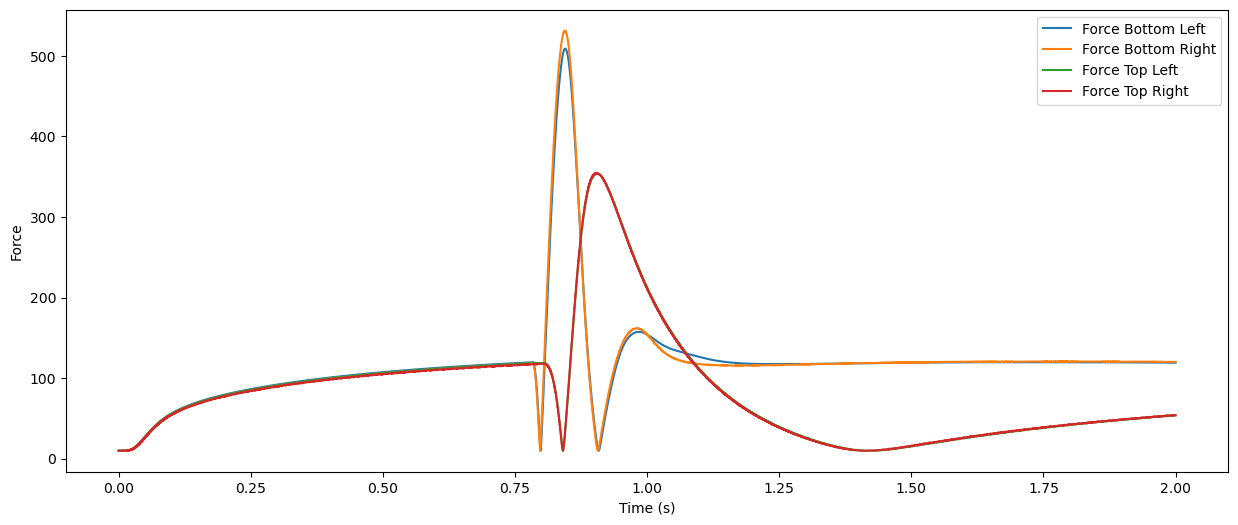

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

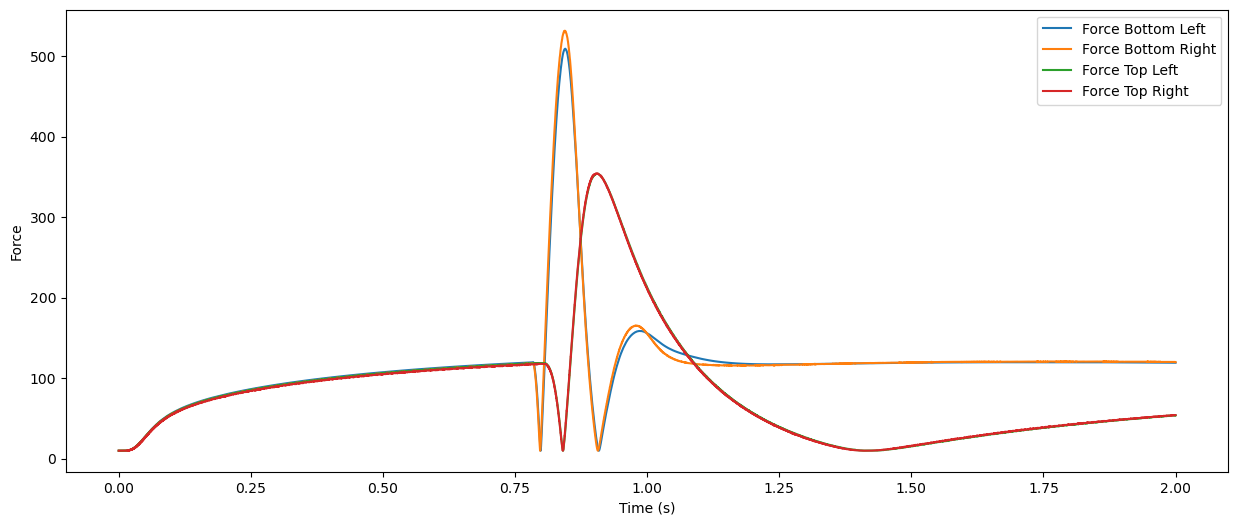

In [4]:
# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
force_bottom_left_filtered = [f for f in force_bottom_left_list if f > 0]
force_bottom_right_filtered = [f for f in force_bottom_right_list if f > 0]
force_top_left_filtered = [f for f in force_top_left_list if f > 0]
force_top_right_filtered = [f for f in force_top_right_list if f > 0]

# Ensure filtered force arrays have the same length as time
num_filtered = min(len(time), len(force_bottom_left_filtered), len(force_bottom_right_filtered), len(force_top_left_filtered), len(force_top_right_filtered))
time = time[:num_filtered]
force_bottom_left_filtered = force_bottom_left_filtered[:num_filtered]
force_bottom_right_filtered = force_bottom_right_filtered[:num_filtered]
force_top_left_filtered = force_top_left_filtered[:num_filtered]
force_top_right_filtered = force_top_right_filtered[:num_filtered]

plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_filtered, label='Force Bottom Left')
plt.plot(time, force_bottom_right_filtered, label='Force Bottom Right')
plt.plot(time, force_top_left_filtered, label='Force Top Left')
plt.plot(time, force_top_right_filtered, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

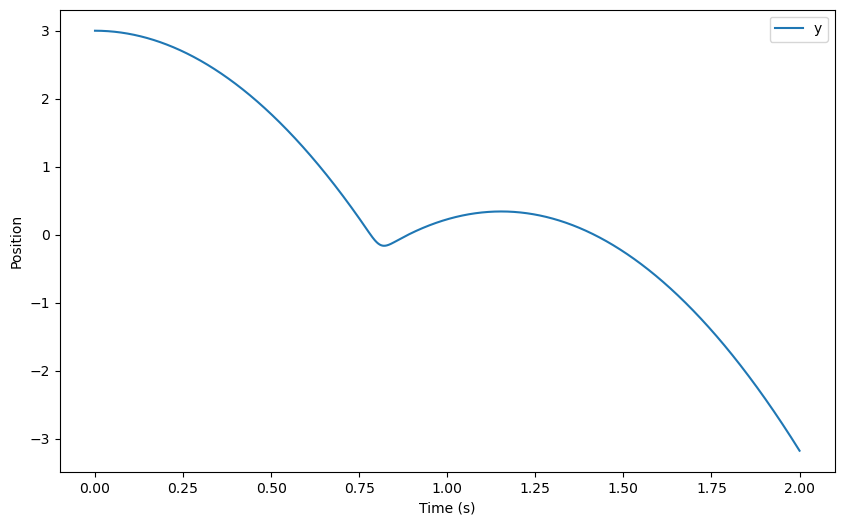

In [3]:
# Convert the ball_positions list to a NumPy array
ball_positions = np.array(ball_positions)

# Adjust the lengths of time and ball position arrays
time = np.arange(steps) * dt
num_positions = min(len(time), ball_positions.shape[0])
time = time[:num_positions]
ball_positions = ball_positions[:num_positions]

# Extract x, y, z positions separately
ball_x = ball_positions[:, 0]
ball_y = ball_positions[:, 1]
ball_z = ball_positions[:, 2]

# Plot the time/position diagram
plt.figure(figsize=(10, 6))
#plt.plot(time, ball_x, label='x')
plt.plot(time, ball_y, label='y')
#plt.plot(time, ball_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.show()

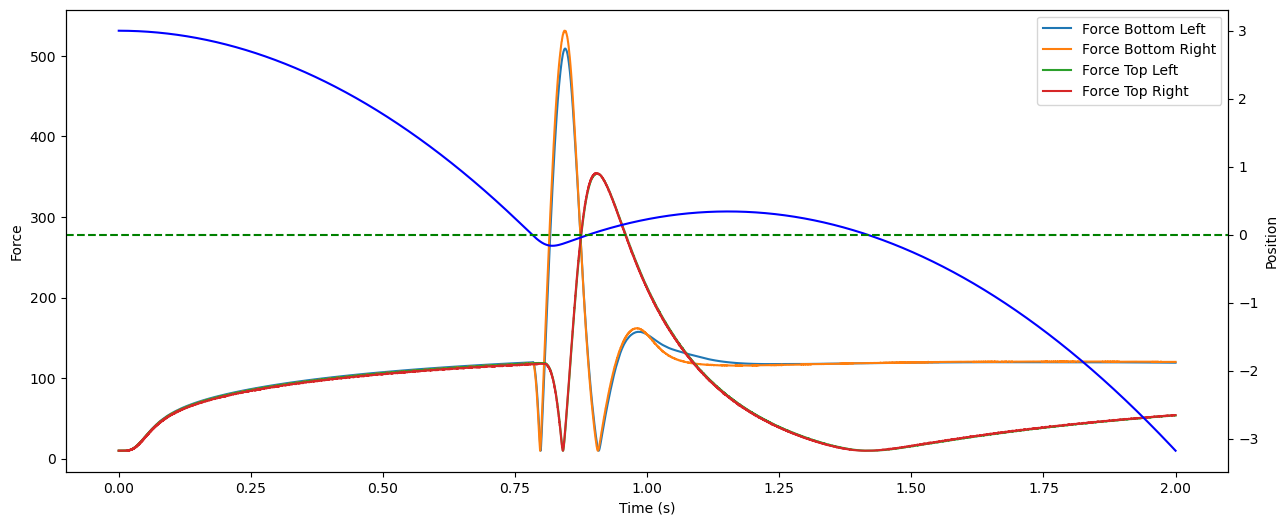

In [4]:
# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')

# Create a second y-axis for ball positions
plt2 = plt.twinx()
plt2.plot(time, ball_y, 'b', label='Ball Position (y)')
plt2.set_ylabel('Position')

# Draw a horizontal line at position = 0
plt.axhline(y=0, color='g', linestyle='--', label='Position = 0')

# Show both plots
plt.show()